In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
graph = pd.read_csv('graph1.csv')
graph

,X,Y
0,-9.505532,-1.213911
1,-9.537238,-1.190135
2,-9.602733,-1.142895
3,-9.670953,-1.096052
4,-9.741833,-1.049585
...,...,...
1189,-9.561457,-5.896860
1190,-9.541278,-5.843891
1191,-9.524437,-5.790518
1192,-9.510979,-5.736402


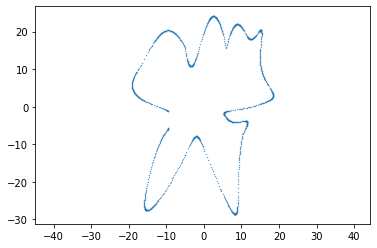

In [6]:
plt.axis('equal')
plt.scatter(np.array(graph['X']), np.array(graph['Y']), s=0.1)
plt.savefig('预处理前.png')

In [7]:
def cal_distance(pos_1, pos_2):
    return np.sqrt((pos_1[0] - pos_2[0]) ** 2 + (pos_1[1] - pos_2[1]) ** 2)

In [8]:
def cal_array_distance(array):
    dis = 0
    for i in range(len(array)-1):
        dis += cal_distance(array[i], array[i+1])
    return dis

In [9]:
total_pos_array = np.array(graph)

In [48]:
def pre_process_array(array):
    end = len(array) - 1
    index = 0
    while index < end:
        while cal_distance(array[index], array[index+1]) > 0.8:
            mean_x = (array[index][0] + array[index+1][0]) / 2
            mean_y = (array[index][1] + array[index+1][1]) / 2
            array = np.insert(array, index + 1, np.array([mean_x, mean_y]), axis=0)
        index += 1
        end = len(array) - 1

    end = len(array) - 1
    index = 0
    while index < end:
        while cal_distance(array[index], array[index+1]) < 0.4:
            array = np.delete(array, index + 1, axis=0)
            end = len(array) - 1
            if index >= end:
                break
        index += 1
        end = len(array) - 1
    return array

In [106]:
total_pos_array = pre_process_array(total_pos_array)

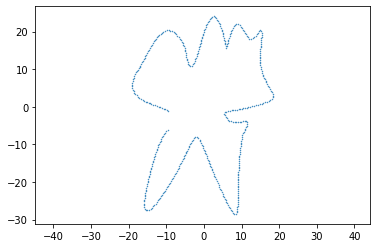

In [109]:
plt.axis('equal')
plt.scatter(total_pos_array[:,0], total_pos_array[:,1], s=0.2)
plt.savefig('预处理后.png')

In [9]:
def get_adjoin_pos_array_by_index(pos_array, index, num):
    if index - num < 0:
        array = np.concatenate((pos_array[len(pos_array) + index - num:],
                                pos_array[:index + num+1]))
    elif index + num > len(pos_array) - 1:
        array = np.concatenate((pos_array[:num - (len(pos_array) - index)],
                                pos_array[index - num -1:]))
    else:
        array = pos_array[index - num:index + num + 1]

    return array

In [10]:
def cal_gradient(pos_array):
    mat = np.mat(pos_array)
    x = np.array(np.array(mat[:,0]).flatten())
    y = np.array(np.array(mat[:,1]).flatten())
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    gradient = p.deriv()
    return gradient(pos_array[int((len(pos_array) - 1) / 2)][0])

In [11]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

#Python3.6
def cross(p1,p2,p3):#跨立实验
    x1=p2.x-p1.x
    y1=p2.y-p1.y
    x2=p3.x-p1.x
    y2=p3.y-p1.y
    return x1*y2-x2*y1

def IsIntersec(p1,p2,p3,p4): #判断两线段是否相交
    #快速排斥，以l1、l2为对角线的矩形必相交，否则两线段不相交
    if(max(p1.x,p2.x)>=min(p3.x,p4.x)    #矩形1最右端大于矩形2最左端
    and max(p3.x,p4.x)>=min(p1.x,p2.x)   #矩形2最右端大于矩形最左端
    and max(p1.y,p2.y)>=min(p3.y,p4.y)   #矩形1最高端大于矩形最低端
    and max(p3.y,p4.y)>=min(p1.y,p2.y)): #矩形2最高端大于矩形最低端

    #若通过快速排斥则进行跨立实验
        if(cross(p1,p2,p3)*cross(p1,p2,p4)<=0
           and cross(p3,p4,p1)*cross(p3,p4,p2)<=0):
            D=1
        else:
            D=0
    else:
        D=0
    return D

In [12]:
def cross_prod(p, q):
    return p[0]*q[1]-p[1]*q[0]

def judge_intersect(line_1, line_2):
    if cross_prod(line_1[0]-line_2[0], line_2[1]-line_2[0]) * cross_prod(line_2[1]-line_2[0], line_1[1]-line_2[0]) >= 0:
        return True
    else:
        return False

In [13]:
judge_intersect(np.array([[0,0],[1,1]]), np.array([[0,0],[1,2]]))

True

In [14]:
def judge_inner_point(pos_1, pos_2, pos_array):
    intersect_num = 0
    for i in range(len(pos_array) - 1):
        if IsIntersec(Point(pos_1[0], pos_1[1]), Point(pos_2[0], pos_2[1]),
                      Point(pos_array[i][0], pos_array[i][1]),
                      Point(pos_array[i+1][0], pos_array[i+1][1])):
            intersect_num += 1
    if intersect_num % 2 == 0:
        return True
    else:
        return False

In [15]:
def judge_valid_point(pos, pos_array, distance):
    for each in pos_array:
        if cal_distance(pos, each) < 0.9 * distance:
            return False
    return True

In [16]:
def get_new_profile_point(pos_array, distance, ptr_pos, valid_pos_array):
    k = cal_gradient(pos_array)
    k = - 1 / k
    pow_distance_x = 1
    pow_distance_y = np.power(k, 2)
    sum = pow_distance_x + pow_distance_y
    pow_distance_x, pow_distance_y = pow_distance_x / sum, pow_distance_y / sum
    distance_x = np.sqrt(pow_distance_x) * distance
    distance_y = np.sqrt(pow_distance_y) * distance
    pos = pos_array[int((len(pos_array) - 1) / 2)]
    if k >= 0:
        point_0 = np.array([pos[0] - distance_x, pos[1] - distance_y])
        point_1 = np.array([pos[0] + distance_x, pos[1] + distance_y])
    else:
        point_0 = np.array([pos[0] - distance_x, pos[1] + distance_y])
        point_1 = np.array([pos[0] + distance_x, pos[1] - distance_y])

    if judge_inner_point(ptr_pos, point_0, valid_pos_array) \
            and judge_valid_point(point_0, valid_pos_array, distance):
        return point_0
    elif judge_inner_point(ptr_pos, point_1, valid_pos_array) \
            and judge_valid_point(point_1, valid_pos_array, distance):
        return point_1
    else:
        return None

In [52]:
import datetime

valid_array = get_adjoin_pos_array_by_index(total_pos_array,500,500)
start = datetime.datetime.now()
judge_inner_point([0,0],[1,1], valid_array)
end = datetime.datetime.now()
(end - start) * 30

datetime.timedelta(microseconds=149610)

In [29]:
import datetime

start = datetime.datetime.now()
new_pos_array = []
ptr_pos = total_pos_array[0]
total_pos_array = pre_process_array(total_pos_array)
for i in range(len(total_pos_array)):
    array = get_adjoin_pos_array_by_index(total_pos_array, i, 1)
    valid_array = get_adjoin_pos_array_by_index(total_pos_array, i, 20)
    new_pos = get_new_profile_point(array, 1, ptr_pos, valid_array)
    if new_pos is not None:
        if cal_distance(new_pos, ptr_pos) < 1.8:
            ptr_pos = new_pos
            new_pos_array.append(new_pos)

new_pos_array = np.array(new_pos_array)
end = datetime.datetime.now()
end - start

datetime.timedelta(seconds=1, microseconds=213909)

In [ ]:
# plt.scatter(total_pos_array[:,0], total_pos_array[:,1], s=0.2, c='blue', label='Original')
# plt.scatter(new_pos_array[:,0], new_pos_array[:,1], s=0.2, c='red', label='New')
# plt.axis('equal')
# plt.legend()
# plt.savefig('1.png')

In [ ]:
total_pos_array = new_pos_array
